# Summary

課題の再提出をする。モデルの評価がきっちりできていなかったのでできるようになっている点がUpdateである。あとは個人的課題。

## 個人課題

前回は、取り組みはTrainデータをあまりいじらない方向で活動し、Logistics回帰のROCスコアは0.51, Gradient Boosting ClassifierのROCスコアが0.70であった。つまり闇雲に特徴料を打ち込むパターンで行った。その取り組みでの個人的な課題は、
   - Kaggleとはいえ、信用スコアリングを相手にした課題なのに、説明変数と目的変数の説明ができないこと
   - Kaggleでスコアにつなげられていないこと
の二つだった。

## 取り組み
特に、今回はディフォルトを説明できるようになれないかと考え課題に取り組んだ。


参考にする過去の論文（＊）のアプローチをベースに、特徴量をたった19個に絞り込み取り組んだ。Logistics回帰のROCスコアは0.55, Gradient Boosting ClassifierのROCスコアが0.73まで上がった。論文は、そもそも銀行マンが信用スコアリングをする、重視する特徴がいくつかあり、景気のインデックスや、地域差を考慮するとデフォルトを予測しやすくなったというものだった。

今回の取り組みにより、一般的な特徴量がここでも説明変数になり得ているのではないかという勘所を得られたと考えている。

銀行マンが重視する特徴は、以下であった。

- 返済負担率
- 借入時年齢
- 勤続年数
- 完済時年齢
- 年収
- 健康状態
- 担保評価
- 連帯保証
- 雇用形態
- 地域
- 景気インデックス


今回は上記に似た特徴量を選択して取り組んだ。
直接的になかった特徴量は、今与えられている特徴を計算して割り出すアプローチにした。

- 返済負担率 :AMT_INCOME_TOTALとAMT_ANNUITYとAMT_GOODS_PRICEから、自己資金率を作成
- 借入時年齢 :与えられているがDaysだったので、年に直した。
- 勤続年数   :与えられているがDaysだったので、年に直した。
- 完済時年齢 :AMT_CREDITをAMT_INCOME_TOTALで割って出した（収入の25％を支払いに当てるとした）
- 年収       :与えられている
- 健康状態   :なし
- 担保評価   :AMT_GOODS_PRICEを利用
- 連帯保証   :なし
- 雇用形態   :ORGANIZATION_TYPEとOCCUPATION_TYPEで代用
- 地域     :REGION_POPULATIONという人口密集地域を指すデータをカテゴリカルデータにして代用
- 景気インデックス：なし


結果、参照した特徴量は以下の19である。

'CODE_GENDER'
'NAME_CONTRACT_TYPE',
'Cap_Adeq_Ratio', 
'Acid_Ratio', 
'Age_of_Completion',
'Years_Old', 
'Years_Employed',
'Lifetime_employed_Ratio',
'Period_of_Payment',
'OCCUPATION_TYPE', 
'ORGANIZATION_TYPE',
'NAME_INCOME_TYPE',
'REGION_POPULATION', 
'REGION_RATING_CLIENT',
'REGION_RATING_CLIENT_W_CITY', 
'EXT_SOURCE_1', 
'EXT_SOURCE_2', 
'EXT_SOURCE_3',



## 論文
https://www.terrapub.co.jp/journals/jjssj/pdf/4201/42010025.pdf。



# Importする

In [395]:
# importing modules to 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import norm, skew
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# CSVの中身を引っ張りましょう

In [396]:
import pandas as pd
train = pd.read_csv('./application_train.csv')
test = pd.read_csv('./application_test.csv')



# CSVの情報を知ります

In [397]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [425]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 307511 to 356254
Columns: 115 entries, SK_ID_CURR to REGION_RATING_CLIENT_W_CITY_3
dtypes: float64(10), int64(2), uint8(103)
memory usage: 9.6 MB


# 前処理

前処理の方針：Trainデータだけで122特徴量あり、またTestデータが別のIDで存在していると考えられたため、Mergeすることにして、トレーニングとテストで同じ条件で使えるデータを増やす。とくにテストデータでも同じ条件で使いたいため。

In [398]:
# reset_indexのなかのdrop=Trueを使うことで、前の特徴のNamingを踏襲する。
train_test = train.append(test).reset_index(drop=True)
train_test.shape

(356255, 122)

In [399]:
train_test.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴量選択

In [400]:
train_test2 = train_test[['SK_ID_CURR', 'CODE_GENDER', 'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]
train_test2.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,NAME_INCOME_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,100002,M,Cash loans,202500.0,406597.5,24700.5,351000.0,-637,-9461,Laborers,...,Working,-3648.0,-2120,0.018801,2,2,0.083037,0.262949,0.139376,1.0
1,100003,F,Cash loans,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,Core staff,...,State servant,-1186.0,-291,0.003541,1,1,0.311267,0.622246,NaN,0.0
2,100004,M,Revolving loans,67500.0,135000.0,6750.0,135000.0,-225,-19046,Laborers,...,Working,-4260.0,-2531,0.010032,2,2,NaN,0.555912,0.729567,0.0
3,100006,F,Cash loans,135000.0,312682.5,29686.5,297000.0,-3039,-19005,Laborers,...,Working,-9833.0,-2437,0.008019,2,2,NaN,0.650442,NaN,0.0
4,100007,M,Cash loans,121500.0,513000.0,21865.5,513000.0,-3038,-19932,Core staff,...,Working,-4311.0,-3458,0.028663,2,2,NaN,0.322738,NaN,0.0


## 欠損をチェックしましょう

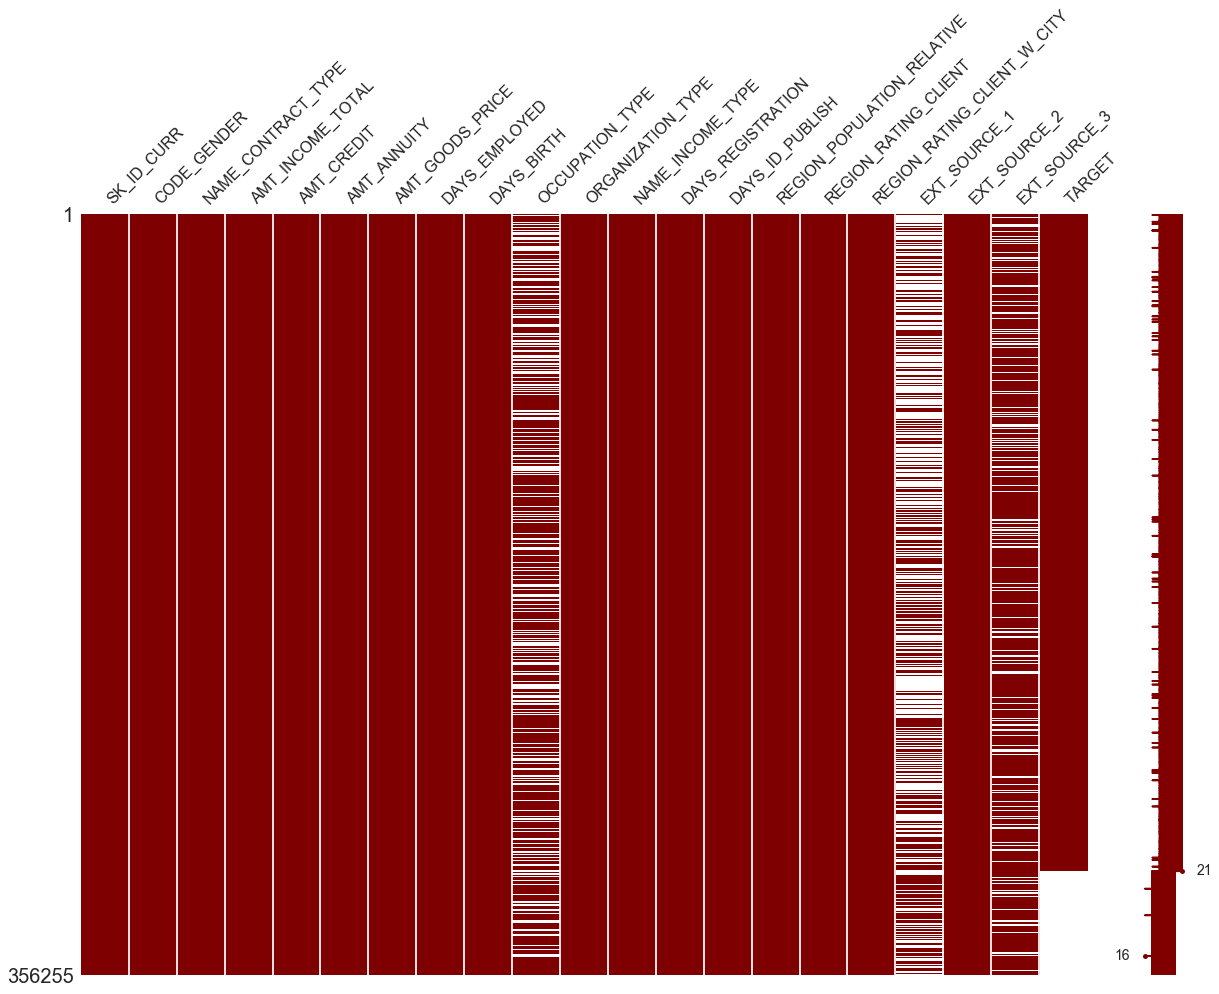

In [401]:
import missingno as msno
msno.matrix(df=train_test2, figsize=(20,14), color=(0.5,0,0))

In [402]:
print(train_test2.isnull().sum())

SK_ID_CURR                          0
CODE_GENDER                         0
NAME_CONTRACT_TYPE                  0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        36
AMT_GOODS_PRICE                   278
DAYS_EMPLOYED                       0
DAYS_BIRTH                          0
OCCUPATION_TYPE                111996
ORGANIZATION_TYPE                   0
NAME_INCOME_TYPE                    0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
REGION_POPULATION_RELATIVE          0
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
EXT_SOURCE_1                   193910
EXT_SOURCE_2                      668
EXT_SOURCE_3                    69633
TARGET                          48744
dtype: int64


# 欠損高いやつは0

In [403]:
# fillna
for c in ['OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    train_test[c].fillna('0', inplace=True)

## AMT Annuity, AMT_Goods_PriceのNANのところに中央値を代入する

In [404]:
for i, t in train_test2.loc[:, train_test2.columns != 'TARGET'].dtypes.iteritems():
    if t == object:
        train_test2[i].fillna(train_test2[i].mode()[0], inplace=True)
        train_test2[i] = LabelEncoder().fit_transform(train_test2[i].astype(str))
    else:
        train_test2[i].fillna(train_test2[i].median(), inplace=True)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## 再度目でもチェック

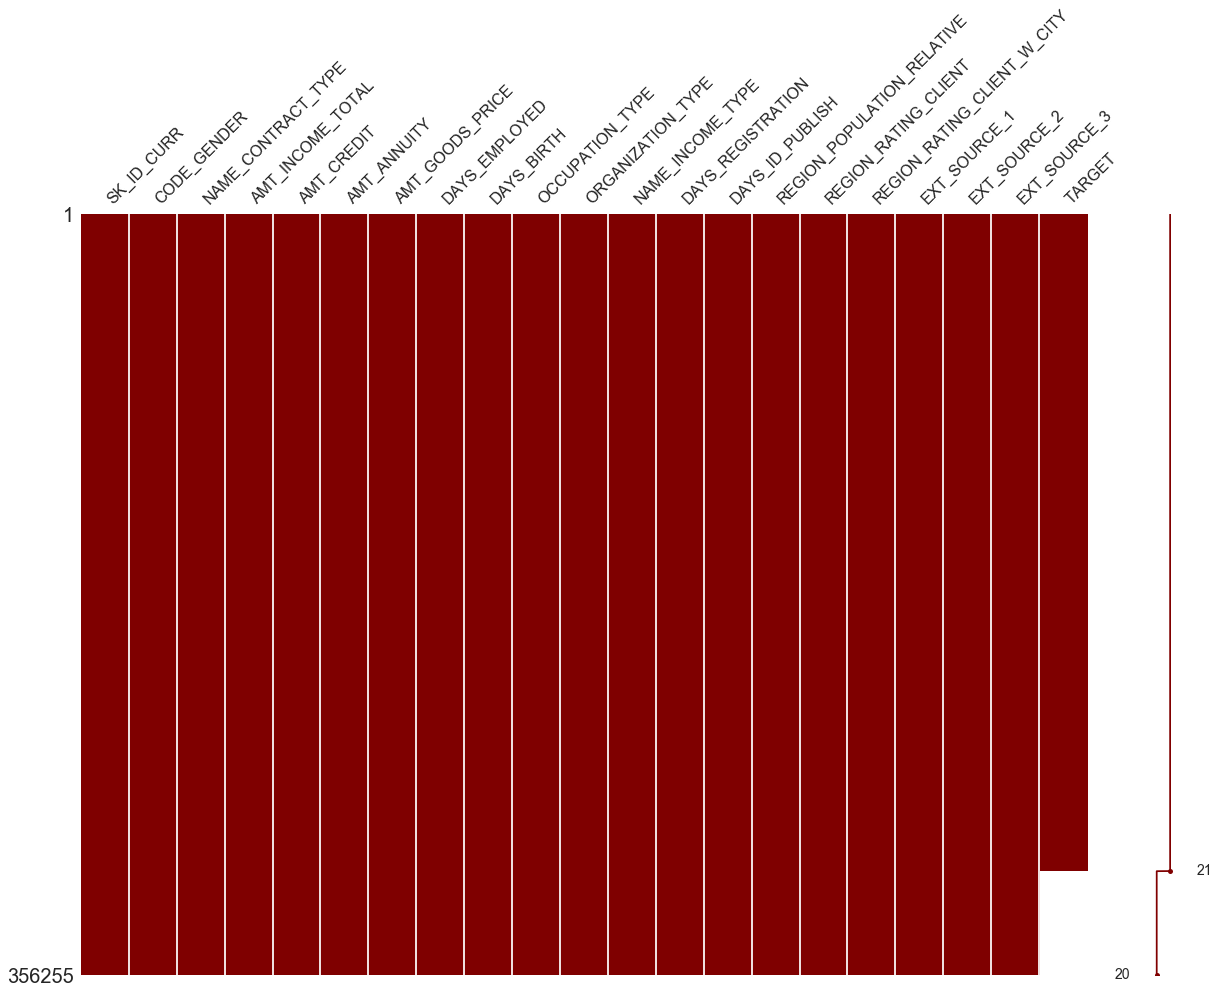

In [319]:
import missingno as msno
msno.matrix(df=train_test2, figsize=(20,14), color=(0.5,0,0))

# 特徴量の追加を図る(外れ値も外す）

## capital adequacy ratio

In [407]:
train_test2['Cap_Adeq_Ratio'] = (train_test2['AMT_INCOME_TOTAL'] + train_test2['AMT_ANNUITY'] + train_test2['AMT_GOODS_PRICE'] ) / train_test2['AMT_CREDIT']
train_test2['Cap_Adeq_Ratio'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean          1.367983
std           0.522405
min           0.516667
25%           1.128660
50%           1.277186
75%           1.493610
max         208.857910
Name: Cap_Adeq_Ratio, dtype: float64

## acid ratio

In [408]:
train_test2['Acid_Ratio'] = train_test2['AMT_CREDIT'] / train_test2['AMT_INCOME_TOTAL'] 
train_test2['Acid_Ratio'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean          3.849476
std           2.635035
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: Acid_Ratio, dtype: float64

## Years_Employed

In [409]:
train_test2['Years_Employed'] = round(train_test2['DAYS_EMPLOYED'] / -365)
train_test2['Years_Employed'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean       -176.272055
std         388.363314
min       -1001.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          49.000000
Name: Years_Employed, dtype: float64

## Years_Old

In [410]:
train_test2['Years_Old'] = round(train_test2['DAYS_BIRTH'] / -365)
train_test2['Years_Old'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean         43.949079
std          11.949155
min          20.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: Years_Old, dtype: float64

## Lifetime_employed_Ratio

In [411]:
train_test2['Lifetime_employed_Ratio'] = train_test2['Years_Employed'] / train_test2['Years_Old'] 
train_test2['Lifetime_employed_Ratio'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean         -2.944224
std           6.648823
min         -47.666667
25%           0.023810
50%           0.089286
75%           0.192308
max           0.731343
Name: Lifetime_employed_Ratio, dtype: float64

## Age_of_Completion(25% of income is credit payable)

In [412]:
train_test2['Age_of_Completion'] = round(train_test2['Years_Old'] + (train_test2['AMT_CREDIT'] / (train_test2['AMT_INCOME_TOTAL'] /4)))
train_test2['Age_of_Completion'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean         59.348026
std          16.846198
min          22.000000
25%          46.000000
50%          58.000000
75%          71.000000
max         398.000000
Name: Age_of_Completion, dtype: float64

## Period_of_Payment

In [413]:
train_test2['Period_of_Payment'] = round(train_test2['Age_of_Completion'] - train_test2['Years_Old'])
train_test2['Period_of_Payment'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    356255.000000
mean         15.398947
std          10.543643
min           0.000000
25%           8.000000
50%          13.000000
75%          20.000000
max         339.000000
Name: Period_of_Payment, dtype: float64

## Region_Populationデータをバンドのデータに変換

In [415]:
r = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.1]
g = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_test2['REGION_POPULATION'] = pd.cut(train_test2['REGION_POPULATION_RELATIVE'], bins=r, labels=g)
train_test2['REGION_POPULATION'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count     356255
unique         9
top            3
freq       68474
Name: REGION_POPULATION, dtype: int64

In [416]:
train_test2.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,OCCUPATION_TYPE,...,EXT_SOURCE_3,TARGET,Cap_Adeq_Ratio,Acid_Ratio,Years_Employed,Years_Old,Lifetime_employed_Ratio,Age_of_Completion,Period_of_Payment,REGION_POPULATION
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,-637,-9461,8,...,0.139376,1.0,1.422046,2.007889,2.0,26.0,0.076923,34.0,8.0,3
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,-1188,-16765,3,...,0.533482,0.0,1.109544,4.790750,3.0,46.0,0.065217,65.0,19.0,0
2,100004,1,1,67500.0,135000.0,6750.0,135000.0,-225,-19046,8,...,0.729567,0.0,1.550000,2.000000,1.0,52.0,0.019231,60.0,8.0,2
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,-3039,-19005,8,...,0.533482,0.0,1.476535,2.316167,8.0,52.0,0.153846,61.0,9.0,1
4,100007,1,0,121500.0,513000.0,21865.5,513000.0,-3038,-19932,3,...,0.533482,0.0,1.279465,4.222222,8.0,55.0,0.145455,72.0,17.0,5


# できた特徴量だけにする

In [417]:
train_test3 = train_test2[['SK_ID_CURR', 'CODE_GENDER', 'NAME_CONTRACT_TYPE', 'Cap_Adeq_Ratio', 'Acid_Ratio', 'Age_of_Completion', 'Years_Old', 'Years_Employed', 'Lifetime_employed_Ratio', 'Period_of_Payment', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_POPULATION', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]
train_test3.head()

,SK_ID_CURR,CODE_GENDER,NAME_CONTRACT_TYPE,Cap_Adeq_Ratio,Acid_Ratio,Age_of_Completion,Years_Old,Years_Employed,Lifetime_employed_Ratio,Period_of_Payment,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REGION_POPULATION,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,100002,1,0,1.422046,2.007889,34.0,26.0,2.0,0.076923,8.0,8,5,7,3,2,2,0.083037,0.262949,0.139376,1.0
1,100003,0,0,1.109544,4.790750,65.0,46.0,3.0,0.065217,19.0,3,39,4,0,1,1,0.311267,0.622246,0.533482,0.0
2,100004,1,1,1.550000,2.000000,60.0,52.0,1.0,0.019231,8.0,8,11,7,2,2,2,0.506155,0.555912,0.729567,0.0
3,100006,0,0,1.476535,2.316167,61.0,52.0,8.0,0.153846,9.0,8,5,7,1,2,2,0.506155,0.650442,0.533482,0.0
4,100007,1,0,1.279465,4.222222,72.0,55.0,8.0,0.145455,17.0,3,37,7,5,2,2,0.506155,0.322738,0.533482,0.0


In [418]:
train_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 20 columns):
SK_ID_CURR                     356255 non-null int64
CODE_GENDER                    356255 non-null int64
NAME_CONTRACT_TYPE             356255 non-null int64
Cap_Adeq_Ratio                 356255 non-null float64
Acid_Ratio                     356255 non-null float64
Age_of_Completion              356255 non-null float64
Years_Old                      356255 non-null float64
Years_Employed                 356255 non-null float64
Lifetime_employed_Ratio        356255 non-null float64
Period_of_Payment              356255 non-null float64
OCCUPATION_TYPE                356255 non-null int64
ORGANIZATION_TYPE              356255 non-null int64
NAME_INCOME_TYPE               356255 non-null int64
REGION_POPULATION              356255 non-null category
REGION_RATING_CLIENT           356255 non-null int64
REGION_RATING_CLIENT_W_CITY    356255 non-null int64
EXT_SOURCE_1            

## 数値データをカテゴリカルデータに変更する

In [419]:
# to categorical feature
cols = ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_POPULATION', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ]
for c in cols:
    train_test3[c] = train_test3[c].astype(str)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## 再度欠損値のチェックをしましょう

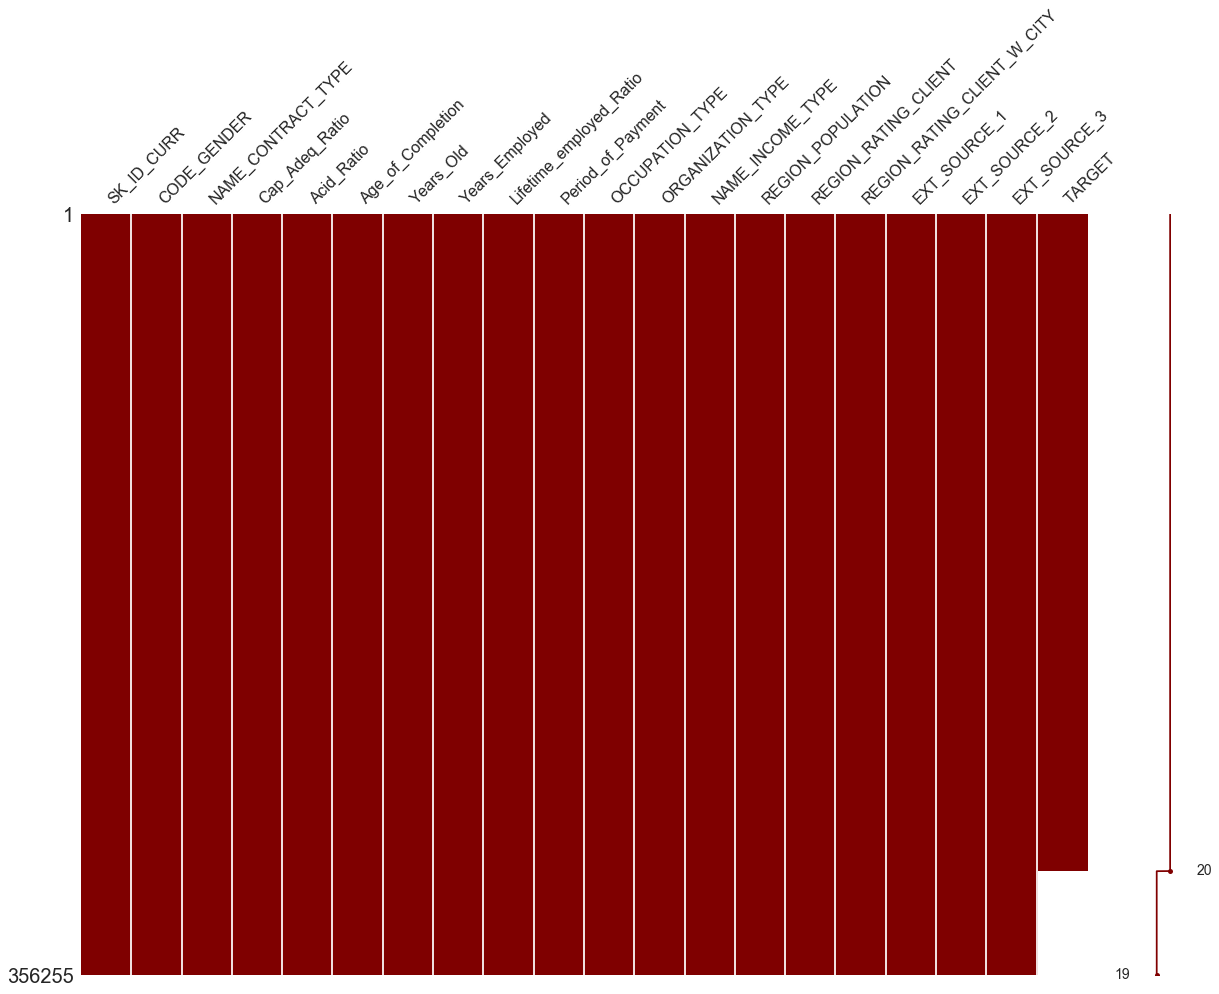

In [420]:
import missingno as msno
msno.matrix(df=train_test3, figsize=(20,14), color=(0.5,0,0))

#  エンコーディング：ラベルとワンホット

## ラベルエンコーダー and ワンホットエンコーダー

In [421]:
#　カラムの中を見て２変数だったらラベルエンコーダーにして&それ以外はワンホットエンコーダーする構文

from sklearn import preprocessing

train_test3_encoded = train_test3
le = preprocessing.LabelEncoder()
for col in train_test3:
   if train_test3[col].dtype == "object":
       if len(list(train_test3[col].unique())) <= 2:
           le.fit(train_test3[col])
           
           train_test3_encoded[col] = le.transform(train_test3[col])
        
train_test3_encoded = pd.get_dummies(train_test3_encoded)
#return df_train_
train_test3_encoded.head(10)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,SK_ID_CURR,NAME_CONTRACT_TYPE,Cap_Adeq_Ratio,Acid_Ratio,Age_of_Completion,Years_Old,Years_Employed,Lifetime_employed_Ratio,Period_of_Payment,EXT_SOURCE_1,...,REGION_POPULATION_6,REGION_POPULATION_7,REGION_POPULATION_9,REGION_RATING_CLIENT_1,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_-1,REGION_RATING_CLIENT_W_CITY_1,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3
0,100002,0,1.422046,2.007889,34.0,26.0,2.0,0.076923,8.0,0.083037,...,0,0,0,0,1,0,0,0,1,0
1,100003,0,1.109544,4.790750,65.0,46.0,3.0,0.065217,19.0,0.311267,...,0,0,0,1,0,0,0,1,0,0
2,100004,1,1.550000,2.000000,60.0,52.0,1.0,0.019231,8.0,0.506155,...,0,0,0,0,1,0,0,0,1,0
3,100006,0,1.476535,2.316167,61.0,52.0,8.0,0.153846,9.0,0.506155,...,0,0,0,0,1,0,0,0,1,0
4,100007,0,1.279465,4.222222,72.0,55.0,8.0,0.145455,17.0,0.506155,...,0,0,0,0,1,0,0,0,1,0
5,100008,0,1.184552,4.954500,66.0,46.0,4.0,0.086957,20.0,0.506155,...,0,1,0,0,1,0,0,0,1,0
6,100009,0,1.029842,9.127053,75.0,38.0,9.0,0.236842,37.0,0.774761,...,0,1,0,0,1,0,0,0,1,0
7,100010,0,1.262794,4.250000,69.0,52.0,1.0,0.019231,17.0,0.506155,...,0,0,0,0,0,1,0,0,0,1
8,100011,0,1.039443,9.063200,91.0,55.0,-1001.0,-18.200000,36.0,0.587334,...,0,0,0,0,1,0,0,0,1,0
9,100012,1,1.383333,3.000000,52.0,40.0,6.0,0.150000,12.0,0.506155,...,0,0,0,0,1,0,0,0,1,0


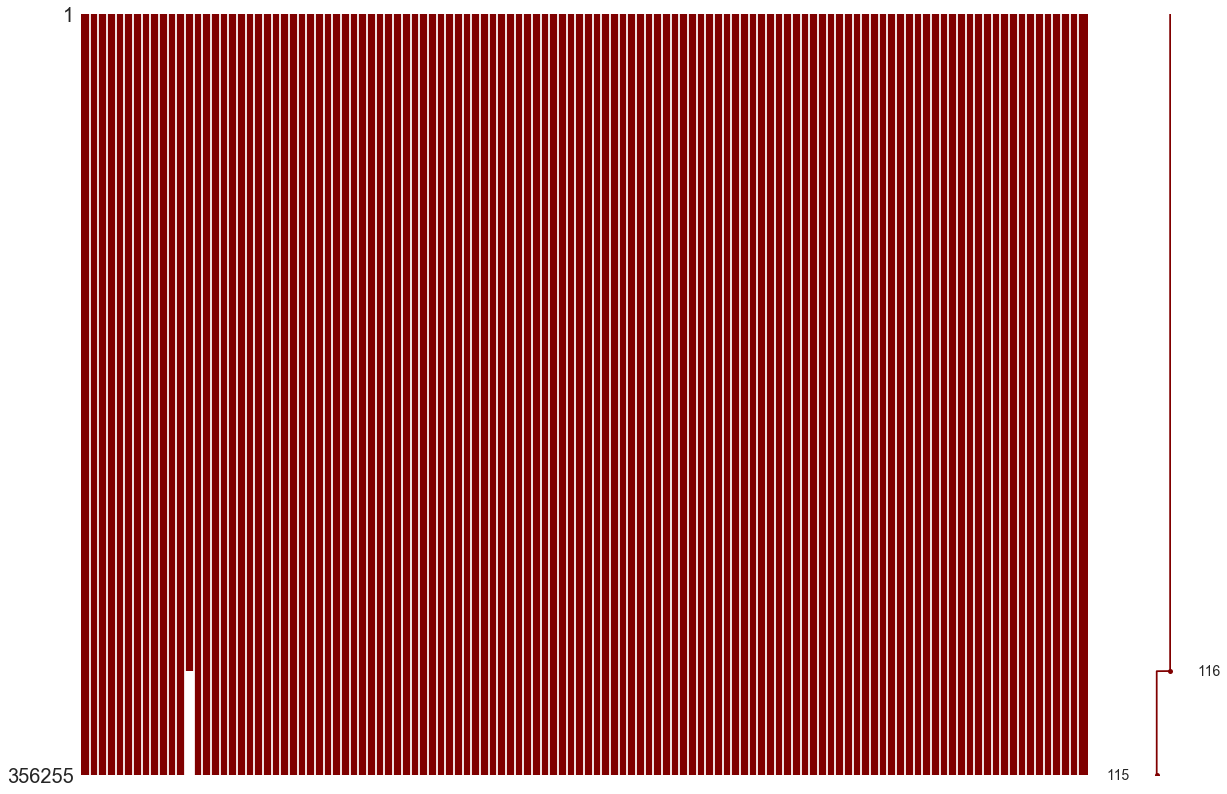

In [422]:
import missingno as msno
msno.matrix(df=train_test3_encoded, figsize=(20,14), color=(0.5,0,0))

# TrainとTestを分ける

## notnullになっている部分をtrainとする

In [423]:
train = train_test3_encoded[train_test3_encoded['TARGET'].notnull()]
train.shape

(307511, 116)

## isnull になっている部分をtest として、そこから目的部分を取り除く

In [424]:
test = train_test3_encoded[train_test3_encoded['TARGET'].isnull()].drop('TARGET', axis=1)
test.shape

(48744, 115)

## 特徴量のカラム名で違いが存在するのが目的変数だけかをチェックする

In [427]:
lost1 = set(train.columns) - set(test.columns)
lost1

{'TARGET'}

In [347]:
#ほかにある場合はdropすることになる
#for c in lost1:
#    #print(c)
#    train = train.drop(c, axis=1)
#print(train.shape)

(250101, 107)


In [428]:
lost2 =  set(test.columns) - set(train.columns)
lost2

set()

In [349]:
# for c in test:
#     #print(c)
#     test = test.drop(c, axis=1)
# print(test.shape)

(38973, 107)


# 外れ値の研究（trainデータのみ）

## 外れ値を消します（6シグマより上下にあるもの）

### Cap_Adeq_Ratio

In [429]:
train['Cap_Adeq_Ratio'].describe()

count    307511.000000
mean          1.355067
std           0.533410
min           0.516667
25%           1.120864
50%           1.265427
75%           1.477857
max         208.857910
Name: Cap_Adeq_Ratio, dtype: float64

In [431]:
train = train[train['Cap_Adeq_Ratio'] < (0.53*6)]
train['Cap_Adeq_Ratio'].describe()

count    305957.000000
mean          1.341494
std           0.324752
min           0.516667
25%           1.120285
50%           1.263352
75%           1.472462
max           3.119971
Name: Cap_Adeq_Ratio, dtype: float64

### Acid_Ratio

In [432]:
train['Acid_Ratio'].describe()

count    305957.000000
mean          3.975334
std           2.684824
min           0.420200
25%           2.037600
50%           3.292000
75%           5.178571
max          84.736842
Name: Acid_Ratio, dtype: float64

In [433]:
train = train[train['Acid_Ratio'] < (2.68*6)]
train['Acid_Ratio'].describe()

count    305049.000000
mean          3.929251
std           2.541809
min           0.420200
25%           2.034063
50%           3.274537
75%           5.147600
max          16.064933
Name: Acid_Ratio, dtype: float64

### Years_Employed

In [434]:
train['Years_Employed'].describe()

count    305049.000000
mean       -174.331517
std         386.715836
min       -1001.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          49.000000
Name: Years_Employed, dtype: float64

In [437]:
train = train[train['Years_Employed'] > -100]
train['Years_Employed'].describe()

count    250289.000000
mean          6.532868
std           6.414579
min           0.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          49.000000
Name: Years_Employed, dtype: float64

## 外れ値が取り除かれているか、目でも確認しておく。

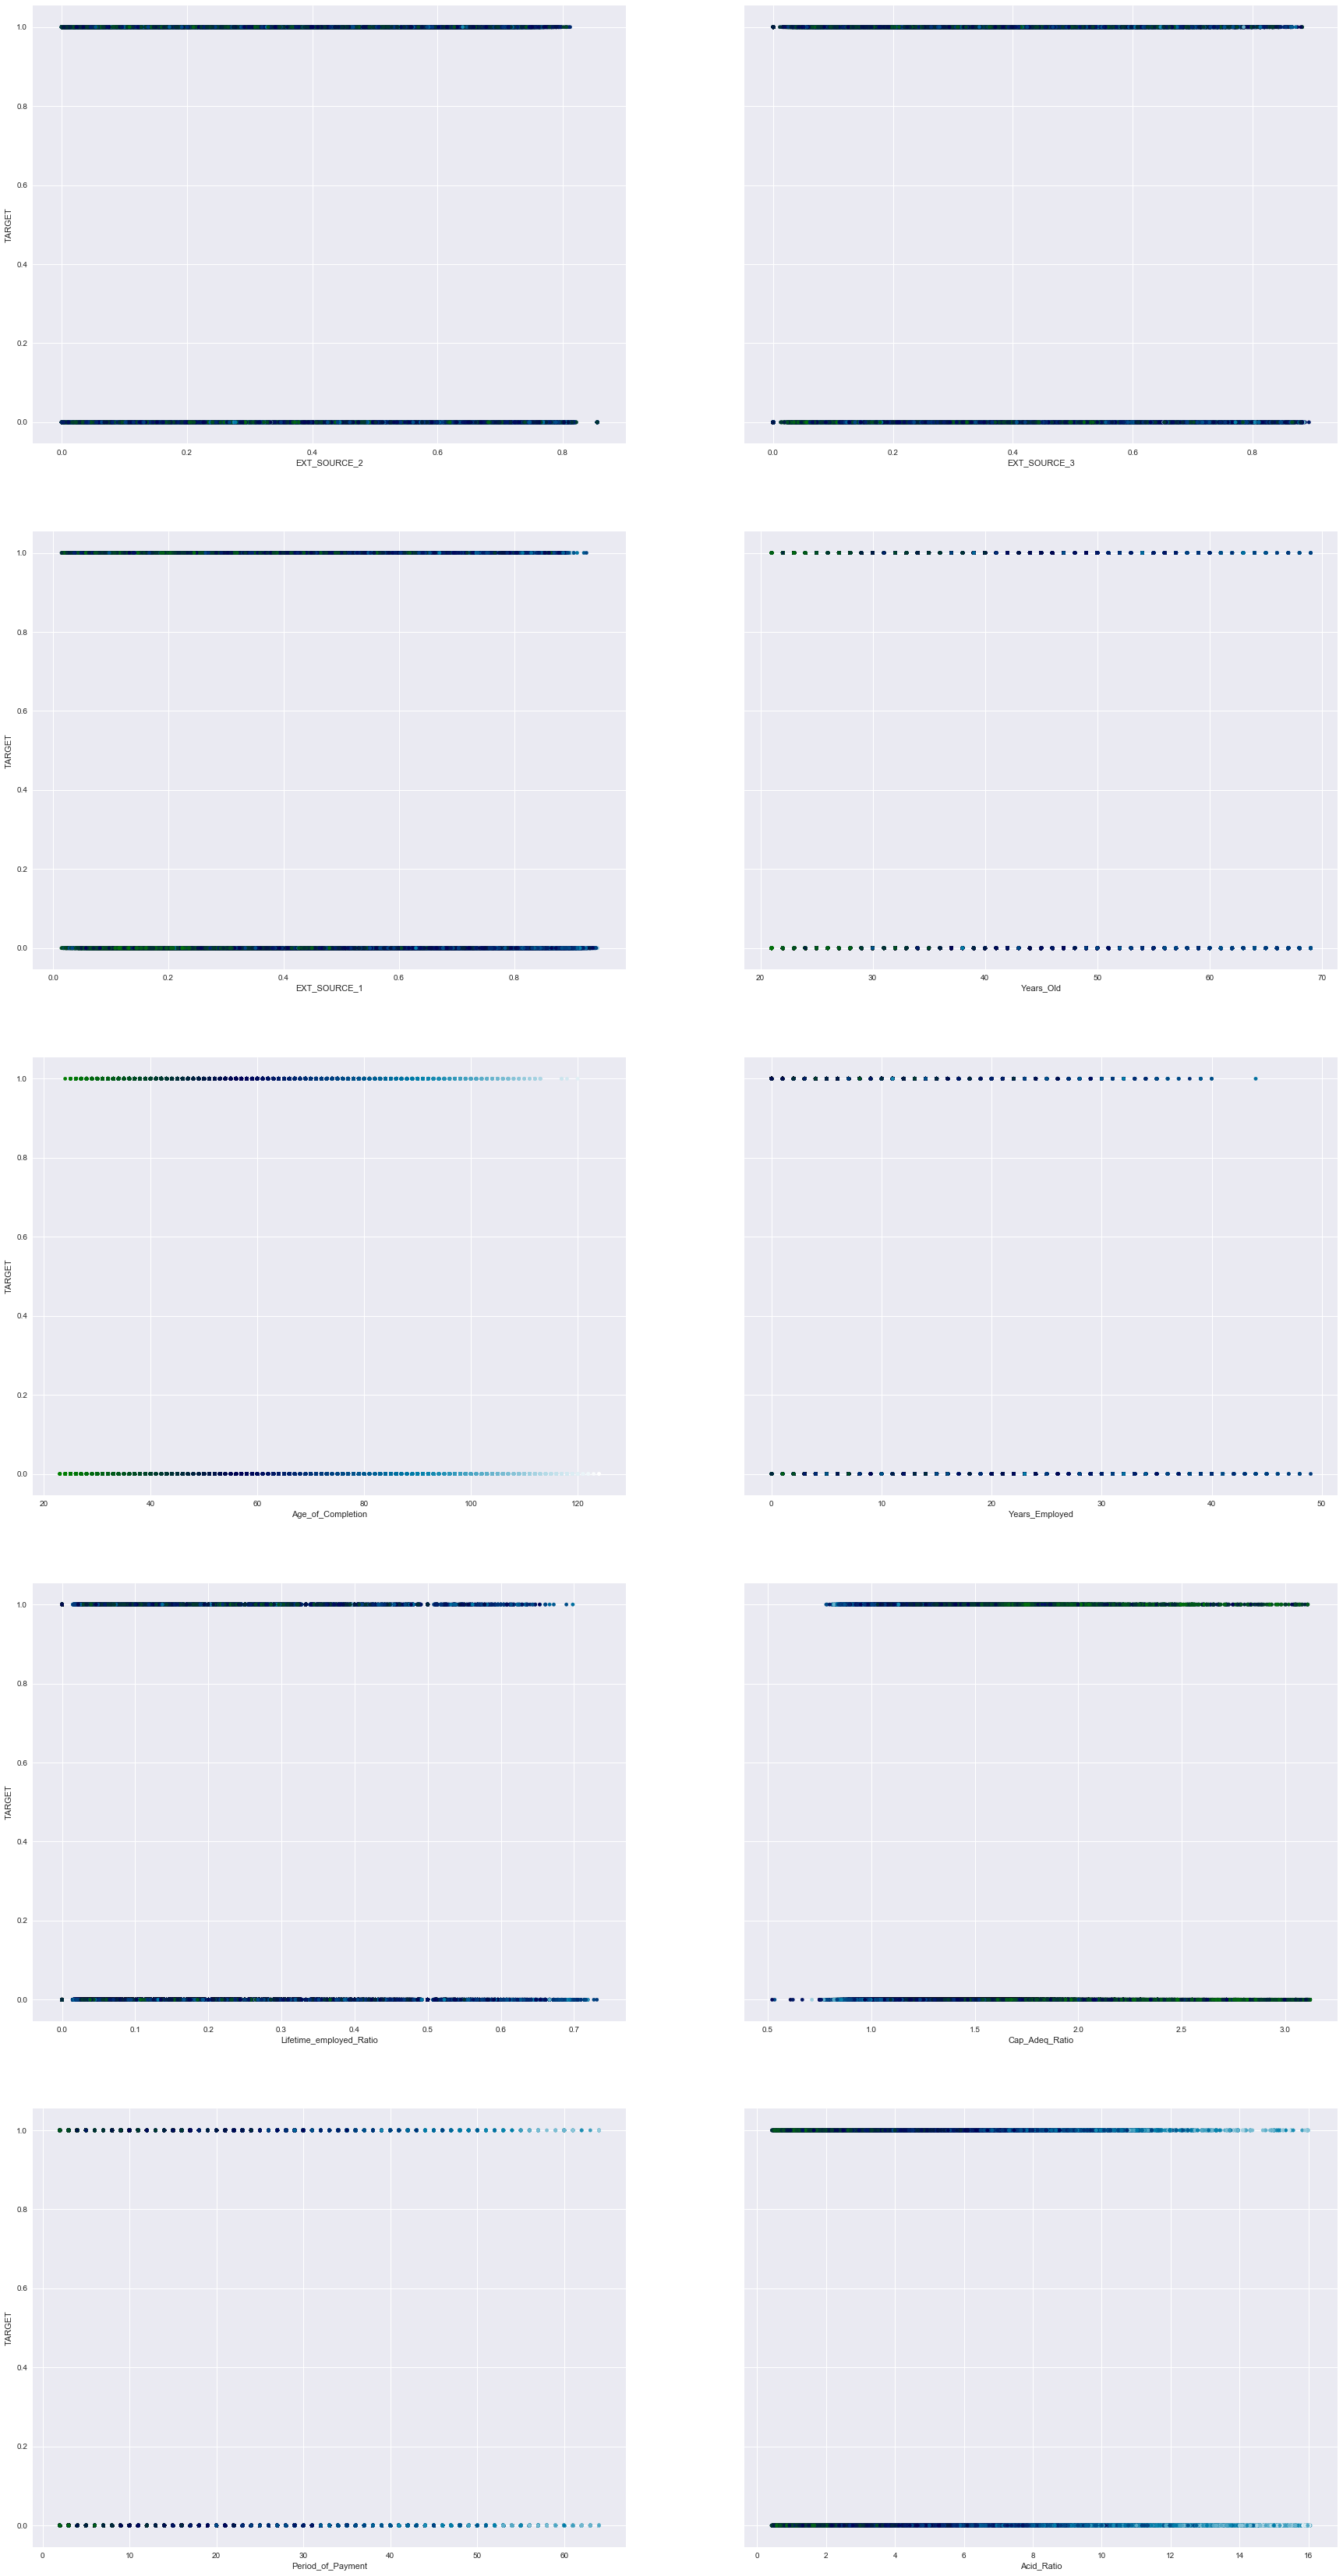

In [438]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(30, 60))
axes = np.ravel(axes)
col_name = corr_target_abs[1:].index
for i in range(10):
    train.plot.scatter(ax=axes[i], x=col_name[i], y='TARGET', c='Age_of_Completion', sharey=True, colorbar=False, cmap='ocean')

# 学習の準備

## trainデータを　XとyとX_testに分けます

In [439]:
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']
X_test = test

print(X.shape, y.shape, X_test.shape)

(250289, 115) (250289,) (48744, 115)


#  学習

## Logistics Regression

In [440]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [441]:
# Submissionを終わらせるためにX_testを使って予測する
# ２行目だけを出すようにする

lr_pred = lr.predict_proba(X_test)[:, 1]
lr_pred

array([ 0.08168402,  0.10726375,  0.08211275, ...,  0.06483366,
        0.07503078,  0.07466307])

In [442]:
submission = pd.DataFrame({
        "SK_ID_CURR": X_test["SK_ID_CURR"],
        "TARGET": lr_pred
    })
submission

,SK_ID_CURR,TARGET
307511,100001,0.081684
307512,100005,0.107264
307513,100013,0.082113
307514,100028,0.120588
307515,100038,0.144102
307516,100042,0.084511
307517,100057,0.114263
307518,100065,0.230672
307519,100066,0.178815
307520,100067,0.229221


### local 評価

In [443]:
from sklearn.model_selection import train_test_split
X_train, X_train_test, y_train, y_train_test = train_test_split(X, y, test_size=0.3)

In [444]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [445]:
#ローカルでのスコア
lr.score(X_train_test, y_train_test)

0.91231504787779505

In [446]:
lr_pred_loc = lr.predict_proba(X_train_test)[:, 1]
lr_pred_loc

array([ 0.13664629,  0.10029433,  0.13726905, ...,  0.03558072,
        0.09802479,  0.02641591])

In [447]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_test, lr_pred_loc)

0.55886257848344978

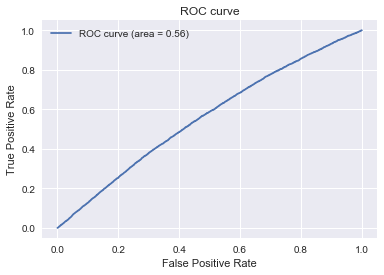

In [448]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_train_test, lr_pred_loc)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label ='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## Gradient Boosting Classifier

In [449]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
        max_depth=1).fit(X, y)


In [463]:
gbc_pred = gbc.predict_proba(X_test)[:, 1]
gbc_pred

array([ 0.076911  ,  0.08673437,  0.03910053, ...,  0.05026871,
        0.05495184,  0.13041993])

In [464]:
submission_gbc = pd.DataFrame({
        "SK_ID_CURR": X_test["SK_ID_CURR"],
        "TARGET": gbc_pred
    })
submission_gbc

,SK_ID_CURR,TARGET
307511,100001,0.076911
307512,100005,0.086734
307513,100013,0.039101
307514,100028,0.045330
307515,100038,0.106515
307516,100042,0.059057
307517,100057,0.033831
307518,100065,0.075222
307519,100066,0.034669
307520,100067,0.151875


In [465]:
#CSVへ吐き出す
submission_gbc.to_csv('submission_gbm.csv')

### local 評価

In [453]:
from sklearn.model_selection import train_test_split
X_train, X_train_test, y_train, y_train_test = train_test_split(X, y, test_size=0.3)

In [454]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
        max_depth=1).fit(X_train, y_train)

In [455]:
#ローカルでのスコア
gbc.score(X_train_test, y_train_test)

0.91315407460678943

In [456]:
gbc_pred_loc = gbc.predict_proba(X_train_test)[:, 1]
gbc_pred_loc

array([ 0.24250041,  0.04507035,  0.06136326, ...,  0.04918448,
        0.06606855,  0.03314358])

In [457]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_test, gbc_pred_loc)

0.73139111484545971

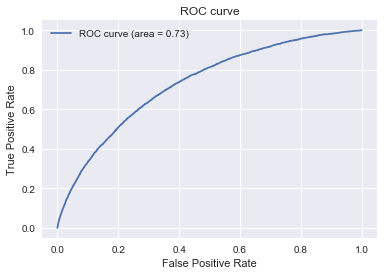

In [458]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_train_test, gbc_pred_loc)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label ='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## Naive Bayes

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB # ガウシアン
# 正規分布を仮定したベイズ分類
gnb = GaussianNB() 
gnb.fit(X, y) # 学習をする


In [ ]:
gnb_pred = gnb.predict_proba(X_test)[:, 1]
gnb_pred

In [ ]:
submission_gnb = pd.DataFrame({
        "SK_ID_CURR": X_test["SK_ID_CURR"],
        "TARGET": gnb_pred
    })
submission_gnb

In [ ]:
#CSVへ吐き出す
submission_gnb.to_csv('submission_gnb.csv')

### local 評価

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_train_test, y_train, y_train_test = train_test_split(X, y, test_size=0.3)

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB # ガウシアン
# 正規分布を仮定したベイズ分類
gnb = GaussianNB() 
gnb.fit(X_train, y_train) # 学習をする

In [ ]:
#ローカルでのスコア
gnb.score(X_train_test, y_train_test)

In [ ]:
gnb_pred_loc = gnb.predict_proba(X_train_test)[:, 1]
gnb_pred_loc

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_test, gnb_pred_loc)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_train_test, gnb_pred_loc)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label ='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)